Saving 03_vasil_4_f_M_22_95.jpg to 03_vasil_4_f_M_22_95.jpg
Saving 12_loukas_1_f_M_20_60.jpg to 12_loukas_1_f_M_20_60.jpg


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Loss: 0.6873

✅ Accuracy : 100.00%
🚨 Recall   : 1.00
⚖️  F1-Score : 1.00


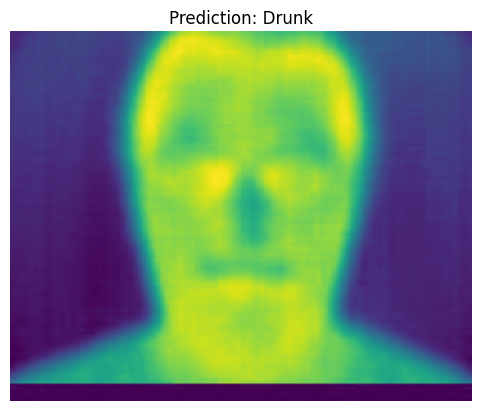

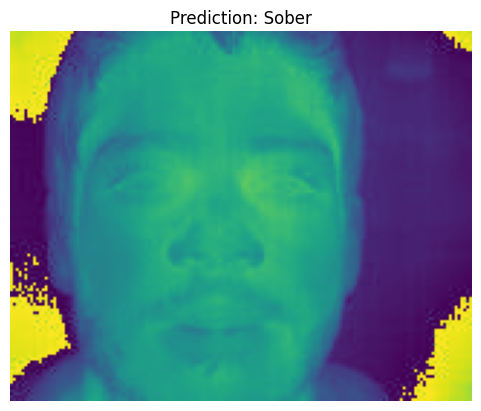

In [ ]:
# ================================
# STEP 0: Install + Download Required Assets (run in Colab)
# ================================
#!pip install dlib torchvision matplotlib
#!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
#!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

# ================================
# STEP 1: Imports and Setup
# ================================
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import cv2
import dlib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score
from google.colab import files

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ================================
# STEP 2: Upload Images
# ================================
uploaded = files.upload()
image_paths = list(uploaded.keys())
labels = [1, 0]  # Adjust this list according to uploaded image order

# ================================
# STEP 3: Utility Functions for Cues
# ================================
def compute_ear(eye):
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    return (A + B) / (2.0 * C)

def compute_eor(eye):
    A = np.linalg.norm(eye[1] - eye[5])
    C = np.linalg.norm(eye[0] - eye[3])
    return A / C

def compute_mar(mouth):
    A = np.linalg.norm(mouth[13] - mouth[19])
    B = np.linalg.norm(mouth[14] - mouth[18])
    C = np.linalg.norm(mouth[12] - mouth[16])
    return (A + B) / (2.0 * C)

# ================================
# STEP 4: Preprocessing and Feature Extraction
# ================================
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def extract_cues(img_gray):
    ear = eor = mar = tai = cntd = 0.0
    faces = detector(img_gray)
    if faces:
        shape = predictor(img_gray, faces[0])
        landmarks = np.array([[p.x, p.y] for p in shape.parts()])
        le, re = landmarks[36:42], landmarks[42:48]
        mouth = landmarks[48:68]

        ear = (compute_ear(le) + compute_ear(re)) / 2
        eor = (compute_eor(le) + compute_eor(re)) / 2
        mar = compute_mar(mouth)

        lt = img_gray[landmarks[2][1], landmarks[2][0]]
        rt = img_gray[landmarks[14][1], landmarks[14][0]]
        tai = abs(lt - rt) / 255.0
        nose = img_gray[landmarks[30][1], landmarks[30][0]]
        cntd = abs(((lt + rt)/2) - nose) / 255.0

    return [min(ear, 0.4), min(eor, 0.4), min(mar, 1.0), min(tai, 1.0), min(cntd, 1.0)]

# ================================
# STEP 5: Custom Dataset
# ================================
class IRImageDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        cues = extract_cues(img_gray)
        aux = torch.tensor(cues, dtype=torch.float32)

        img = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
        img = transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, aux, label

# ================================
# STEP 6: DrunkNet Model
# ================================
class DrunkNet(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.mobilenet_v2(pretrained=True)
        for param in base.features.parameters():
            param.requires_grad = False

        self.features = base.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc_img = nn.Sequential(
            nn.Linear(base.last_channel, 64), nn.ReLU(), nn.Dropout(0.2)
        )
        self.fc_aux = nn.Sequential(nn.Linear(5, 32), nn.ReLU())
        self.fc_combined = nn.Linear(96, 2)

    def forward(self, img, aux):
        x = self.pool(self.features(img))
        x = self.flatten(x)
        img_feat = self.fc_img(x)
        aux_feat = self.fc_aux(aux)
        combined = torch.cat((img_feat, aux_feat), dim=1)
        return self.fc_combined(combined)

# ================================
# STEP 7: Train and Evaluate
# ================================
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for img, aux, label in dataloader:
        img, aux, label = img.to(DEVICE), aux.to(DEVICE), label.to(DEVICE)
        optimizer.zero_grad()
        output = model(img, aux)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for img, aux, label in dataloader:
            img, aux = img.to(DEVICE), aux.to(DEVICE)
            output = model(img, aux)
            preds = torch.argmax(output, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(label.numpy())
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n✅ Accuracy : {acc*100:.2f}%")
    print(f"🚨 Recall   : {rec:.2f}")
    print(f"⚖️  F1-Score : {f1:.2f}")

# ================================
# STEP 8: Run Training Pipeline
# ================================
dataset = IRImageDataset(image_paths, labels)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

model = DrunkNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loss = train(model, dataloader, optimizer, criterion)
print(f"Training Loss: {train_loss:.4f}")

evaluate(model, dataloader)

# ================================
# STEP 9: Visualize Predictions
# ================================
def visualize_predictions(model, image_paths):
    model.eval()
    for path in image_paths:
        img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        cues = extract_cues(img_gray)
        aux = torch.tensor([cues], dtype=torch.float32).to(DEVICE)
        img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
        img_tensor = transform(img_rgb).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model(img_tensor, aux)
            pred = torch.argmax(out).item()
            plt.imshow(Image.open(path))
            plt.title(f"Prediction: {'Drunk' if pred == 1 else 'Sober'}")
            plt.axis("off")
            plt.show()

visualize_predictions(model, image_paths)

# ================================
# Cue Thresholds (for reference only)
# ================================
# EAR < 0.21      → Drowsiness or Impairment
# EOR < 0.15      → Eye partially closed
# MAR > 0.5       → Frequent yawning or open mouth
# TAI > 0.2       → Temperature imbalance (drunken asymmetry)
# CNTD > 0.1      → Cheek-nose temp difference
# These thresholds help us bound cue values and normalize them
